# LAS Demo

This is a demonstration of how `run_exp.py` works and the result of example config file.
May NOT be executable due to modification of model code in latest version.

## Notes :

    1. The goal is simply to reconstructed LAS and see if it works on TIMIT, all paremeters are NOT fine tuned.

    2. I run the experiment once with unassigned random seed and get the result.
    
    3. Run with smaller batch may help stablize testing performance. (but slowing down training process)
    
    4. The model trained on example config can be find in `checkpoint/`
    


## Package & Config setting

In [1]:
import yaml
from util.timit_dataset import load_dataset,create_dataloader
from util.functions import log_parser,batch_iterator, collapse_phn
from model.las_model import Listener,Speller
import numpy as np
from torch.autograd import Variable
import torch
import time
import matplotlib.pyplot as plt
% matplotlib inline

# Load example config file for experiment
config_path = 'config/las_example_config.yaml'
conf = yaml.load(open(config_path,'r'))

# Parameters loading
num_epochs = conf['training_parameter']['num_epochs']
training_msg = 'epoch_{:2d}_step_{:3d}_TrLoss_{:.4f}_TrWER_{:.2f}'
epoch_end_msg = 'epoch_{:2d}_TrLoss_{:.4f}_TrWER_{:.2f}_ValLoss_{:.4f}_ValWER_{:.2f}_time_{:.2f}'
listener_model_path = conf['meta_variable']['checkpoint_dir']+conf['meta_variable']['experiment_name']+'.listener'
speller_model_path = conf['meta_variable']['checkpoint_dir']+conf['meta_variable']['experiment_name']+'.speller'
verbose_step = conf['training_parameter']['verbose_step']
tf_rate_upperbound = conf['training_parameter']['tf_rate_upperbound']
tf_rate_lowerbound = conf['training_parameter']['tf_rate_lowerbound']


## Prepare Dataset 

In [2]:
# Load preprocessed TIMIT Dataset
# X : Padding to shape [num of sample, max_timestep, feature_dim]
# Y : Squeeze repeated label and apply one-hot encoding (preserve 0 for <sos> and 1 for <eos>)
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(**conf['meta_variable'])
train_set = create_dataloader(X_train, y_train, **conf['model_parameter'], **conf['training_parameter'], shuffle=True)
valid_set = create_dataloader(X_val, y_val, **conf['model_parameter'], **conf['training_parameter'], shuffle=False)
test_set = create_dataloader(X_test, y_test, **conf['model_parameter'], **conf['training_parameter'], shuffle=False)

## Construct Model

In [ ]:
listener = Listener(**conf['model_parameter'])
speller = Speller(**conf['model_parameter'])
optimizer = torch.optim.Adam([{'params':listener.parameters()}, {'params':speller.parameters()}], 
                              lr=conf['training_parameter']['learning_rate'])

## Training Progress

In [ ]:
best_ler = 1.0
traing_log = open(conf['meta_variable']['training_log_dir']+conf['meta_variable']['experiment_name']+'.log','w')

for epoch in range(num_epochs):
    epoch_head = time.time()
    tr_loss = 0.0
    tr_ler = []
    val_loss = 0.0
    val_ler = []

    # Teacher forcing rate linearly decay
    tf_rate = tf_rate_upperbound - (tf_rate_upperbound-tf_rate_lowerbound)*(epoch/num_epochs)
    
    # Training
    for batch_index,(batch_data,batch_label) in enumerate(train_set):
        batch_loss, batch_ler = batch_iterator(batch_data, batch_label, listener, speller, optimizer, 
                                               tf_rate, is_training=True, **conf['model_parameter'])
        tr_loss += batch_loss
        tr_ler.extend(batch_ler)
        if (batch_index+1) % verbose_step == 0:
            print(training_msg.format(epoch+1,batch_index+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler)),end='\r',flush=True)
    training_time = float(time.time()-epoch_head)
    
    # Validation
    for _,(batch_data,batch_label) in enumerate(valid_set):
        batch_loss, batch_ler = batch_iterator(batch_data, batch_label, listener, speller, optimizer, 
                                               tf_rate, is_training=False, **conf['model_parameter'])
        val_loss += batch_loss
        val_ler.extend(batch_ler)

    # Logger
    print(epoch_end_msg.format(epoch+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler),
                               val_loss[0]/len(valid_set),sum(val_ler)/len(val_ler),training_time),flush=True)
    print(epoch_end_msg.format(epoch+1,tr_loss[0]/(batch_index+1),sum(tr_ler)/len(tr_ler),
                               val_loss[0]/len(valid_set),sum(val_ler)/len(val_ler),training_time),flush=True,file=traing_log)

    # Checkpoint
    if best_ler >= sum(val_ler)/len(val_ler):
        best_ler = sum(val_ler)/len(val_ler)
        torch.save(listener, listener_model_path)
        torch.save(speller, speller_model_path)



# Result Visualization

## Learning Curve & Performance


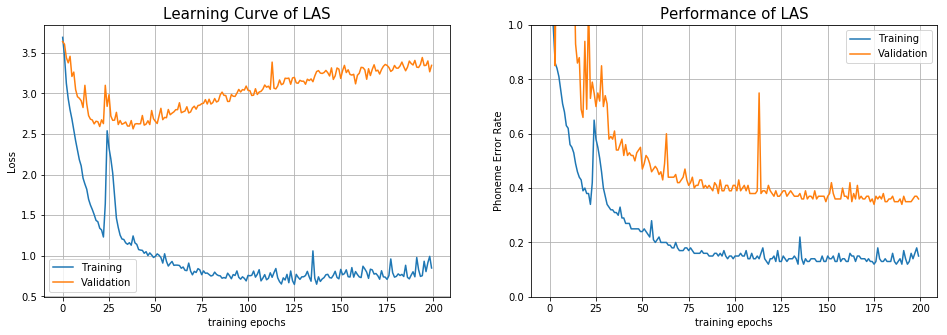

In [3]:
fig, axs = plt.subplots(1,2,figsize=(16,5))
tr_loss, tt_loss, tr_ler, tt_ler = log_parser('log/las_example.log')

axs[0].plot(tr_loss,label='Training');axs[0].plot(tt_loss,label='Validation');
axs[0].legend();axs[0].set_xlabel('training epochs');axs[0].set_ylabel('Loss');
axs[0].set_title('Learning Curve of LAS',size=15);axs[0].grid(True);
axs[1].plot(tr_ler,label='Training');axs[1].plot(tt_ler,label='Validation');axs[1].grid(True);
axs[1].legend();axs[1].set_xlabel('training epochs');axs[1].set_ylabel('Phoneme Error Rate');
axs[1].set_ylim(0,1)
axs[1].set_title('Performance of LAS',size=15)
plt.savefig('log/result.jpg')

## Attention Visualization & Recognition Result

In [4]:
target = 0

listener = torch.load(listener_model_path)
speller = torch.load(speller_model_path)
for batch_index,(batch_data,batch_label) in enumerate(test_set):
    test_sample = batch_data[target:target+1]
    test_label = batch_label[target]
    break
feature = listener(Variable(test_sample.float()).cuda())
pred_seq, attention_score = speller(feature)

encoded_feature_length = int(sum(sum(list(np.sum(test_sample.numpy(),axis=-1)!=0)))/8)

pred = []
att_map = []
truth = []

for pred_phn,att_score,true_phn in zip(pred_seq, attention_score,test_label):
    ground_truth = np.argmax(true_phn.numpy())
    pred.append(np.argmax(pred_phn.cpu().data.numpy()))
    att_map.append(att_score.cpu().data.numpy()[0,:encoded_feature_length])
    truth.append(ground_truth)
    if ground_truth == 1:
        break
    
for idx,p in enumerate(pred):
    if p == 1:
        break
att_map = np.array(att_map)  
pred = collapse_phn(pred[:idx],return_phn=True,drop_q=False)
pred.extend(['<eos>' for i in range(len(truth)-len(pred))])
truth = collapse_phn(truth[:-1],return_phn=True,drop_q=False)
truth.append('<eos>')

/home/kevin1kevin1k/ADLxMLDS2017/virt/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kevin1kevin1k/ADLxMLDS2017/virt/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/kevin1kevin1k/ADLxMLDS2017/virt/lib/python3.5/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Softmax' has changed. you can retrieve

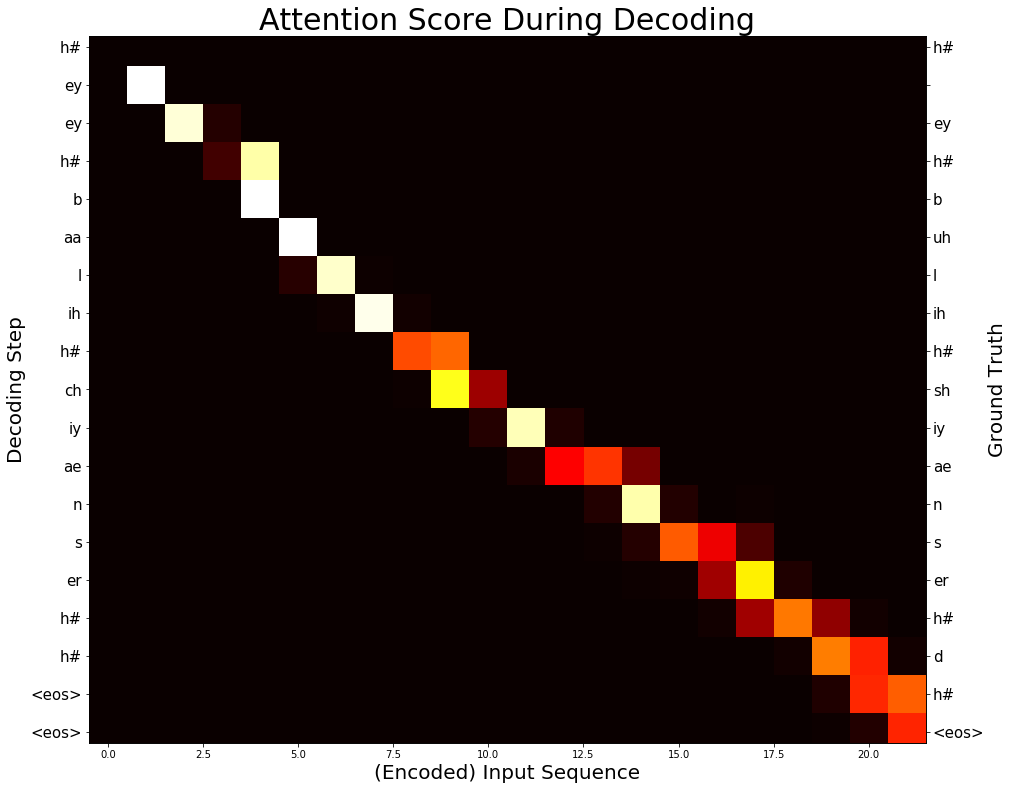

In [5]:
fig,ax = plt.subplots(1,figsize=(15,13))
ax2 = ax.twinx()
plt.title('Attention Score During Decoding',size=30)
ax.set_xlabel('(Encoded) Input Sequence',size=20)
ax2.set_xlabel('(Encoded) Input Sequence',size=20)

ax.imshow(att_map, cmap='hot')
ax2.imshow(att_map, cmap='hot')

ax.set_yticks(range(len(truth)))
ax.set_yticklabels(pred,size=15)
ax.set_ylabel('Decoding Step',size=20)

ax2.set_yticks(range(len(truth)))
ax2.set_yticklabels(truth,size=15)
ax2.set_ylabel('Ground Truth',size=20)

plt.savefig('log/attention.jpg')

# Testing Performance

In [6]:
from util.functions import LetterErrorRate

test_ler = []
for batch_index,(batch_data,batch_label) in enumerate(test_set):
    feature = listener(Variable(batch_data.float()).cuda())
    pred_seq, _ = speller(feature)
    
    batch_ler = LetterErrorRate(np.argmax(np.array([p.data.cpu().numpy() for p in pred_seq]).transpose(1,0,2),axis=-1),
                                np.argmax(batch_label.numpy(),axis=-1))
    test_ler.extend(batch_ler)

print('Testing Phoneme Error Rate',sum(test_ler)/len(test_ler))
    

/home/kevin1kevin1k/Listen-Attend-and-Spell-Pytorch/model/las_model.py:35: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  output,hidden = self.BLSTM(input_x)
/home/kevin1kevin1k/Listen-Attend-and-Spell-Pytorch/model/las_model.py:78: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  rnn_output, hidden_state = self.rnn_layer(input_word,last_hidden_state)


Testing Phoneme Error Rate 0.34177474215145387
